<a href="https://colab.research.google.com/github/Aurelien07/FAO-2.0/blob/main/FAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAO ou comment utiliser ses données pour un monde meilleur :

Dans ce contexte, j'ai décidé de m'orienter sur une étude me permettant de mettre en valeur certaines datas du site FA0 pour me permettre de mettre en relief un top des marques en fonction de plusieurs critéres qui seront vu au fur et à mesure. On mettra également en avant les additifs, ainsi que le novascore et nutriscore pour avoir une vue globale du produit.

On utilisera une méthode de tags via le NLP pour détecter les allergénes etc etc.

## Import des dépendances :

In [1]:
!pip install langid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import des librairies

In [2]:
import ipywidgets as widgets
from IPython.display import display, HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Lecture du CSV :

In [4]:
df = pd.read_csv("/content/drive/My Drive/FAO/fr.openfoodfacts.org.products.csv",sep='\t')

<ipython-input-4-470ba990abdd>:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/My Drive/FAO/fr.openfoodfacts.org.products.csv",sep='\t')


# Preprocessing :

## Fonction de preprocessing :

In [5]:
import pandas as pd
from IPython.display import display

def detect_missing_data(data: pd.DataFrame):
    """
    Détecte les données manquantes dans un DataFrame.

    Parameters:
    ----------
    data : pd.DataFrame
        Le DataFrame contenant les données.

    Returns:
    -------
    pd.DataFrame
        Un DataFrame avec les colonnes du DataFrame d'origine, une colonne indiquant le nombre de valeurs manquantes par colonne
        et une colonne avec le pourcentage de valeurs manquantes en entier.

    """

    missing_data = data.isnull().sum().reset_index()
    missing_data.columns = ['Colonne', 'Valeurs_manquantes'] # Nommage des colonnes
    missing_data['Pourcentage_manquants'] = (missing_data['Valeurs_manquantes'] / data.shape[0]) * 100 
    missing_data = missing_data[missing_data['Valeurs_manquantes'] > 0].sort_values(by='Valeurs_manquantes', ascending=False)
    missing_data.reset_index(drop=True, inplace=True)
    missing_data['Pourcentage_manquants'] = missing_data['Pourcentage_manquants'].astype(int)  # Conversion en entier (integer)

    return missing_data


def visualize_missing_columns(data: pd.DataFrame):

    """
    Visualise les colonnes avec un certain pourcentage de valeurs manquantes dans un DataFrame.

    Parameters:
    ----------
    data : pd.DataFrame
        Le DataFrame contenant les données.
    """
    threshold = int(input("Entrez le seuil de pourcentage de valeurs manquantes pour la visualisation : "))
    missing_data = detect_missing_data(data)
    missing_data_filtered = missing_data[missing_data['Pourcentage_manquants'] >= threshold]

    display(missing_data_filtered[['Colonne', 'Pourcentage_manquants', 'Valeurs_manquantes']])


Cette fonction me permet de faire une visualisation des données manquantes par colonne et sur la totalité du dataframe. De cette façon je pourrais créer une fonction beaucoup plus intrusive par colonne par la suite pour visualiser les rows etc etc de la colonne.

In [6]:
def filtrer_colonne_sans_nan(dataframe, colonne):
    colonne_filtree = dataframe[colonne].dropna()
    nb_lignes_avant_filtrage = dataframe.shape[0]
    nb_lignes_apres_filtrage = colonne_filtree.shape[0]
    pourcentage_lignes_supprimees = ((nb_lignes_avant_filtrage - nb_lignes_apres_filtrage) / nb_lignes_avant_filtrage) * 100
    
    df_filtre = pd.DataFrame(colonne_filtree, columns=[colonne])
    
    print(f"Le nombre de lignes avant filtrage est de {nb_lignes_avant_filtrage}")
    print(f"Le nombre de lignes après filtrage est de {nb_lignes_apres_filtrage}")
    print(f"Le pourcentage de lignes supprimées après filtrage est de {round(pourcentage_lignes_supprimees, 5)}%\n")
    
    return df_filtre

Cette fonction me permet de recharger directement les rows dans une colonne ou les données ne sont pas manquantes en m'affichant un print avant aprés et le pourcentage supprimées. Evidemment cette fonction n'est que démonstrative et j'ai fait en sorte qu'elle ne soit qu'une visualisation pour notre dataframe.

## Visualisation des données :

On va commencer par faire un .head() pour avoir une visualisation globale de notre dataframe. On utilisera des fonctions par la suite pour nous permettre de détecter les potentielles NaN et de pouvoir les supprimer en toute sécurité.

In [7]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ici, on voit qu'on a un grand nombre de NaN sur la plupart des colonnes, on va donc devoir supprimer un grand nombre de colonne je pense. Mais avant de vouloir les supprimer, il convient de vérifier si il n'y aurait pas un moyen de récupérer certaines de ses données.

Etant parti sur un notebook en français, je vais du coup utiliser les colonnes fr et abandonner les colonnes uk

### Suppression des données non pertinentes :

En premier lieu, on va vérifier un peu notre pourcentage de NaN par colonnes et on va faire une évaluation globale. Ensuite une fois nettoyé on utilisera qu'une infime partie de notre dataset, car un bon nombre de ses données de nous interesse pas.

On va déterminer en utilisant les pourcentage de valeurs manquantes un certain montant..

In [8]:
visualize_missing_columns(df)

Entrez le seuil de pourcentage de valeurs manquantes pour la visualisation : 70


,Colonne,Pourcentage_manquants,Valeurs_manquantes
0,water-hardness_100g,100,320772
1,no_nutriments,100,320772
2,elaidic-acid_100g,100,320772
3,ingredients_that_may_be_from_palm_oil,100,320772
4,nutrition_grade_uk,100,320772
...,...,...,...
114,categories_tags,73,236383
115,categories,73,236362
116,categories_fr,73,236361
117,pnns_groups_1,71,229259


On voit déjà ici que ces colonnes n'ont aucun interet nous n'avons aucune donnée.

In [9]:
df.columns.tolist()

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_fr',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_fr',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_fr',
 'ingredients_text',
 'allergens',
 'allergens_fr',
 'traces',
 'traces_tags',
 'traces_fr',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_fr',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

In [10]:
df = df[['product_name','brands','categories_fr','origins','labels_fr','allergens_fr','ingredients_text','additives_fr',
         'nutrition_grade_fr','main_category_fr','image_url','energy_100g', 
         'fat_100g','saturated-fat_100g','trans-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','alcohol_100g',
         'nutrition-score-fr_100g']]

In [11]:
visualize_missing_columns(df)

Entrez le seuil de pourcentage de valeurs manquantes pour la visualisation : 0


,Colonne,Pourcentage_manquants,Valeurs_manquantes
0,allergens_fr,99,320753
1,alcohol_100g,98,316639
2,origins,93,298582
3,labels_fr,85,274106
4,image_url,76,244936
5,main_category_fr,73,236406
6,categories_fr,73,236361
7,trans-fat_100g,55,177474
8,additives_fr,51,166092
9,fiber_100g,37,119886


In [12]:
def visualize_missing_data(data: pd.DataFrame):
    """
    Affiche un aperçu des valeurs manquantes dans un DataFrame, y compris un graphique.

    Parameters:
    ----------
    data : pd.DataFrame
        Le DataFrame contenant les données.

    """
    total_missing = data.isnull().sum().sort_values(ascending=False)
    percent_missing = (total_missing / data.shape[0])

    missing_data = pd.DataFrame({
        'Total manquant': total_missing,
        'Pourcentage manquant': percent_missing.round(2)*100
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x='Pourcentage manquant', y=missing_data.index, data=missing_data, ax=ax)
    ax.set(xlabel='Pourcentage manquant', ylabel='Variables', title='Aperçu des valeurs manquantes')
    plt.show()

    print('-' * 100)
    print(" " * 41, '\033[1m' + "Données manquantes :" + '\033[0m')
    print('-' * 100)

    print(missing_data)

    print('-' * 100)
    print(" " * 25, '\033[1m' + f"Le pourcentage de données manquantes est de {((percent_missing.sum()/percent_missing.count()).round(2))*100}%" + '\033[0m')


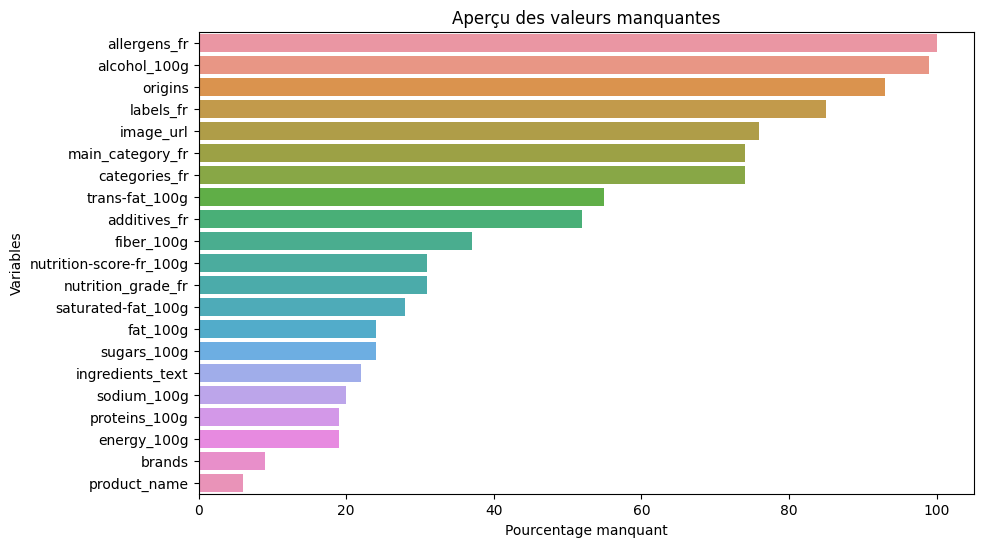

----------------------------------------------------------------------------------------------------
                                          Données manquantes :
----------------------------------------------------------------------------------------------------
                         Total manquant  Pourcentage manquant
allergens_fr                     320753                 100.0
alcohol_100g                     316639                  99.0
origins                          298582                  93.0
labels_fr                        274106                  85.0
image_url                        244936                  76.0
main_category_fr                 236406                  74.0
categories_fr                    236361                  74.0
trans-fat_100g                   177474                  55.0
additives_fr                     166092                  52.0
fiber_100g                       119886                  37.0
nutrition-score-fr_100g           99562              

In [13]:
visualize_missing_data(df)

#### Modification de la colonne fiber_100g

On peut considérer que si la colonne fiber_100g n'a pas de données, c'est que le produit ne posséde pas de fibres.

In [14]:
df['fiber_100g'] = df['fiber_100g'].fillna(0) # On remplace chaque NaN par un 0.

In [15]:
filtrer_colonne_sans_nan(df, 'allergens_fr')

Le nombre de lignes avant filtrage est de 320772
Le nombre de lignes après filtrage est de 19
Le pourcentage de lignes supprimées après filtrage est de 99.99408%



,allergens_fr
189068,http://fr.openfoodfacts.org/images/products/30...
189103,http://fr.openfoodfacts.org/images/products/30...
189109,http://fr.openfoodfacts.org/images/products/30...
189119,http://fr.openfoodfacts.org/images/products/30...
189152,http://fr.openfoodfacts.org/images/products/30...
189160,http://fr.openfoodfacts.org/images/products/30...
189162,http://fr.openfoodfacts.org/images/products/30...
189168,http://fr.openfoodfacts.org/images/products/30...
189242,http://fr.openfoodfacts.org/images/products/30...
189244,http://fr.openfoodfacts.org/images/products/30...


## Preprocessing via NLP :

In [16]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import langid

### Fonction importantes :